In [102]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.preprocessing import LabelEncoder

from stellargraph import globalvar
from stellargraph import datasets
from stellargraph import StellarGraph
from IPython.display import display, HTML
%matplotlib inline

import ast
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [2]:
# retrieving data and putting into pandas dataframe
c_cites = pd.read_csv(
    '../data/cora.cites.csv',
    # sep="\t",
    # header=None,
    names=["target", "source"],
    ) # no column unique
c_cites = c_cites.drop(0)
c_cites['target'] = c_cites['target'].apply(pd.to_numeric)
c_cites['source'] = c_cites['source'].apply(pd.to_numeric)
print(c_cites.head())
print(c_cites.shape)

   target  source
1      35     887
2      35    1033
3      35    1688
4      35    1956
5      35    8865
(5429, 2)


In [75]:
G = StellarGraph(edges=c_cites)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  default: [2708]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [5429]
        Weights: all 1 (default)
        Features: none


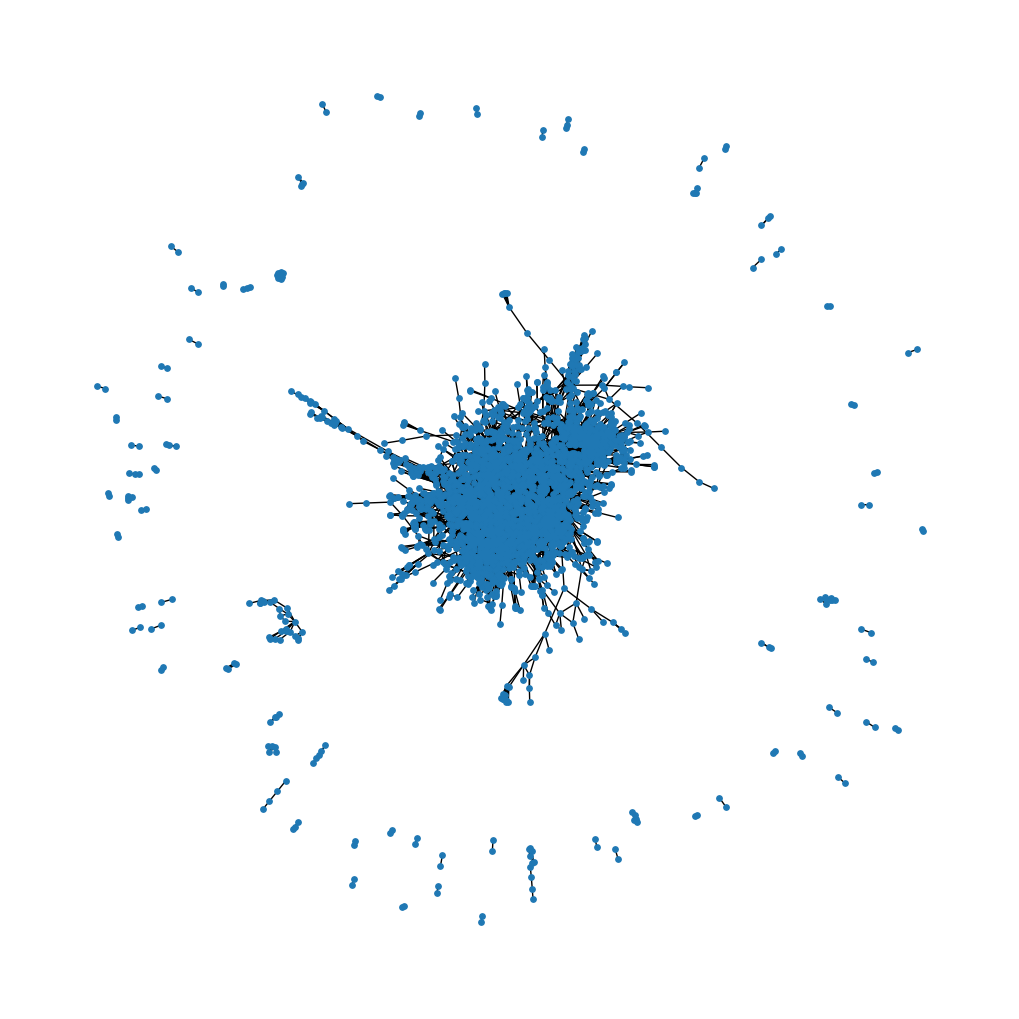

In [8]:
gx = StellarGraph.to_networkx(G)

plt.figure(figsize=(10, 10))
# colors = c_paper["subject"].tolist()
# cora_graph = nx.from_pandas_edgelist(c_cites.sample(n=1500))
# subjects = list(c_paper[c_paper["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(gx, node_size=15) #, node_color=subjects)

In [114]:
def gen():
    with open('../data/outputacm.txt', 'r',  encoding="utf8") as f:
        datum={}
        citations =[]
        row=0
        readFile = f.readlines()
        for line in readFile:
            # if row > 10:
            #     break
            # else:
            #     if line == '\n':
            #         print("New Line!")
            #     print(line)
            #     row = row + 1
            #     continue
            if '#index' in line:
                citations =[]
                datum['id'] = line[6:].rstrip()
                if bool(datum):
                    datum['citations'] = citations
                    try:
                        for i in range(len(datum['author'])):
                            
                            datum_to_save = datum.copy()
                            datum_to_save['author']=datum['author'][i] # saving each author as a separate paper
                            # datum_to_save['affiliation']=datum['affiliation'][i]
                            # print(datum)
                            yield datum_to_save
                            row+=1
                    except IndexError as e:
                        continue
                    
                    datum={}
                    
                
            elif '#*' in line:
                datum['title'] = line[2:].rstrip()
            elif '#@' in line:
                datum['author'] = line[2:].rstrip()# .rsplit(",")
            # elif '#o' in line:
            #     datum['affiliation'] = line[3:].rstrip().rsplit(";")
            elif '#t' in line:
                datum['year'] = line[2:].rstrip()
            elif '#c' in line:
                datum['venue'] = line[2:].rstrip()
            elif '#%' in line:
                citations.append(line[2:].rstrip())
            elif '#!' in line:
                datum['abstract'] = line[2:].rstrip()


data = pd.DataFrame(gen(), columns =('id', 'title', 'author', 'year', 
                                  'venue', 'citations', 'abstract'))
data['year'] =pd.to_numeric(data['year'], errors = 'coerce').fillna(0)

data.to_csv("../data/outputacm.csv", encoding='utf-8')

KeyboardInterrupt: 

In [35]:
cnet = pd.read_csv(
    '../data/outputacm.csv',
    ) # no column unique
print(cnet.shape)
print(cnet.head())

(1337974, 8)
   Unnamed: 0  id                                              title  \
0           0   0  Automated Deduction in Geometry: 5th Internati...   
1           1   0  Automated Deduction in Geometry: 5th Internati...   
2           2   1  A+ Certification Core Hardware (Text & Lab Man...   
3           3   2  Performance engineering in industry: current p...   
4           4   2  Performance engineering in industry: current p...   

              author  year                                              venue  \
0          Hoon Hong  2006                                                NaN   
1      Dongming Wang  2006                                                NaN   
2  Charles J. Brooks  2003                                                NaN   
3    Ahmed E. Hassan  2007  Proceedings of the 6th international workshop ...   
4    Parminder Flora  2007  Proceedings of the 6th international workshop ...   

  citations abstract  
0        []      NaN  
1        []      NaN 

In [96]:
cites = cnet.drop(['title', 'author', 'year', 'venue', 'abstract', 'Unnamed: 0'], axis=1)
cites.citations = cites.citations.apply(ast.literal_eval)
cites = cites.explode('citations')
cites = cites.dropna()
cites.rename(columns = {'id':'source', 'citations':'target'}, inplace = True)

In [103]:
node_feat = cnet.drop(['citations', 'Unnamed: 0', 'abstract'], axis=1)
node_feat = node_feat.set_index('id')
print(node_feat)
print(node_feat.columns)

                                                    title  \
id                                                          
0       Automated Deduction in Geometry: 5th Internati...   
0       Automated Deduction in Geometry: 5th Internati...   
1       A+ Certification Core Hardware (Text & Lab Man...   
2       Performance engineering in industry: current p...   
2       Performance engineering in industry: current p...   
...                                                   ...   
629811  Multimodal system evaluation using modality ef...   
629812                       Computer System Architecture   
629813  Oppositional target domain estimation using gr...   
629813  Oppositional target domain estimation using gr...   
629813  Oppositional target domain estimation using gr...   

                       author  year  \
id                                    
0                   Hoon Hong  2006   
0               Dongming Wang  2006   
1           Charles J. Brooks  2003   
2          

In [107]:
print(node_feat.dtypes)

title     object
author    object
year       int64
venue     object
dtype: object


In [110]:
node_feat = node_feat.apply(LabelEncoder().fit_transform)

In [98]:
cites = cites.reset_index()
cites

,index,source,target
0,9,5,436405
1,10,5,436405
2,36,17,357875
3,36,17,214023
4,36,17,317448
...,...,...,...
1639625,1337968,629811,302639
1639626,1337968,629811,572828
1639627,1337969,629811,294663
1639628,1337969,629811,302639


In [111]:
G = StellarGraph(nodes=node_feat, edges=cites)
print(G.info())

ValueError: expected IDs to appear once, found some that appeared more: 0, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 17, 21, 23, 24, 25, 28, 35, 37, 49, ... (365846 more)

In [79]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 163963 positive and 163963 negative edges. **


In [80]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 147566 positive and 147566 negative edges. **


In [81]:
epochs = 50

In [82]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

RuntimeError: This StellarGraph has no numeric feature attributes for nodesNode features are required for machine learning